# Homework 7: scikit-image

Due Tuesday Apr 10, 6pm

## Counting objects

In class, we saw how to count the number of objects in a microscopy image.  Here, we will repeat that exercise, but make use of some of the algorithms in `scikit-image` to segment the image, and then to determine properties of the resulting objects.

As input, use the image `skimage.data.coins`.  Segment the image, and then calculate the area and eccentricity of each coin.

There are various ways to do this.  One would be:

1. Equalize the input image (see `skimage.exposure`)
2. Threshold the image (`skimage.filters.otsu`)
3. Remove objects touching the boundary (`skimage.segmentation.clear_border`)
4. Apply morphological closing (`skimage.morphology.closing`)
5. Remove small objects (`skimage.measure.regionprops`).
   Visualize the results if you want with `skimage.color.label2rgb`.
7. Calculate the area and eccentricity of each coin, and display the
   original image with this information on it (`matplotlib.pyplot.text` or `matplotlib.pyplot.annotate`)

In [1]:
import skimage
from skimage.data import coins
from skimage.exposure import equalize_hist
from skimage.filters import threshold_yen, try_all_threshold, threshold_adaptive, threshold_local
from skimage.segmentation import clear_border
from skimage.morphology import closing
from skimage.measure import regionprops, label
from skimage.color import label2rgb
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects

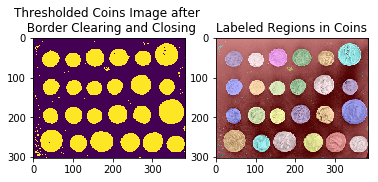

In [2]:
#equalize histogram to assist with thresholding
eq = equalize_hist(coins())
#adaptive thresholding provides the best results when I checked
adapt_thresh = threshold_local(eq, 105)
thresholded = eq>adapt_thresh
#clear border objects and close them
cleared = clear_border(thresholded)
closed = closing(cleared)
plt.subplot(1,2,1)
plt.imshow(closed)
plt.title("Thresholded Coins Image after \n Border Clearing and Closing");
plt.subplot(1,2,2)
#label continuous regions in the image
label_image = label(closed)
#visualize this
image_label_overlay = label2rgb(label_image, image=eq)
plt.imshow(image_label_overlay)
plt.title("Labeled Regions in Coins");


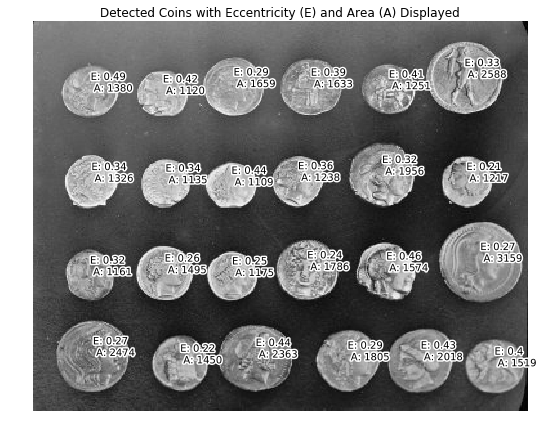

In [6]:

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(coins(), cmap='gray')

#only keep regions with large enouch areas
kept_regions = []
for region in regionprops(label_image):
    if region.area >= 100:
        kept_regions.append(region)
        
        
#label coins in the figure based on the kept regions
for region in kept_regions:
    txt = plt.annotate(s='E: ' + str(round(region.eccentricity,2)) + '\n A: ' +
                 str(region.area), color='k',
                 xy = (region.centroid[1], region.centroid[0]))
    #add a white border for visability
    txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])

ax.set_axis_off()
plt.tight_layout()
plt.gcf().suptitle("Detected Coins with Eccentricity (E) and Area (A) Displayed", y=1);
plt.show()

## Panorama stitching

One of the scikit-image tutorials shows [how to do panorama stitching](https://github.com/scikit-image/skimage-tutorials/blob/master/lectures/solutions/adv3_panorama-stitching-solution.ipynb).

Take 3 or 4 overlapping photos of your own, and use the procedure described to stitch your own panorama.

In [1]:
import skimage.io as sio
import numpy as np
from skimage.color import rgb2grey
from skimage.feature import ORB, match_descriptors, plot_matches
import matplotlib.pyplot as plt
from skimage.transform import rescale, ProjectiveTransform, SimilarityTransform, warp
from skimage.measure import ransac, label
from skimage.filters import gaussian
from skimage.graph import route_through_array

In [2]:
def compare(*images, **kwargs):
    """
    TAKEN FROM THE TUTORIAL :)
    Utility function to display images side by side.
    
    Parameters
    ----------
    image0, image1, image2, ... : ndarrray
        Images to display.
    labels : list
        Labels for the different images.
    """
    labels = kwargs.pop('labels', None)
    if labels is None:
        labels = [''] * len(images)
        
    f, axes = plt.subplots(1, len(images), **kwargs)
    axes = np.array(axes, ndmin=1)
    
    
    for n, (image, label) in enumerate(zip(images, labels)):
        axes[n].imshow(image, interpolation='nearest', cmap='gray')
        axes[n].set_title(label)
        axes[n].axis('off')
    
    f.tight_layout()

/home/hayley/.conda/envs/my_root/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/hayley/.conda/envs/my_root/lib/python3.6/site-packages/skimage/filters/_gaussian.py:108: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  warn(RuntimeWarning(msg))


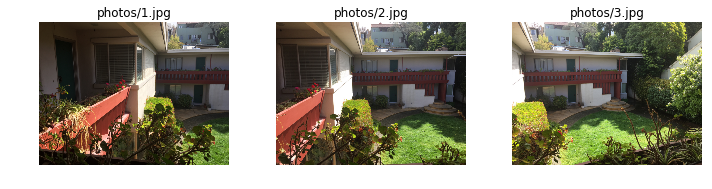

In [3]:
#read in and display starting images
photos_paths = ['photos/1.jpg', 'photos/2.jpg', 'photos/3.jpg']
#read images, converting to greyscale and downscaling. filter w/gaussian to avoid aliasing artifacts
g_images = [rescale(gaussian(rgb2grey(sio.imread(p)),2), (.5,.5)).astype('float32') \
            for p in photos_paths]
images = [rescale(gaussian(sio.imread(p),2), (.5,.5)).astype('float32') \
            for p in photos_paths]

compare(*images, labels = photos_paths, figsize = (10,8))
plt.suptitle = "Original Images"

## Extract Keypoints, Match, and Visualize Results
Using ORB, extract 800 keypoints. Then match them between images using the match_descriptors method from skimage. Using plot_matches, display these matches.

In [4]:
#extract keypoints using ORB
orb = ORB(n_keypoints=800, fast_threshold=0.05)
keypoints = []
descriptors = []
for im in g_images:
    orb.detect_and_extract(im)
    keypoints.append(orb.keypoints)
    descriptors.append(orb.descriptors)

In [5]:
#match descriptors between images
matches01 = match_descriptors(descriptors[0], descriptors[1], cross_check=True)
matches12 = match_descriptors(descriptors[1], descriptors[2], cross_check=True)

/home/hayley/.conda/envs/my_root/lib/python3.6/site-packages/skimage/feature/match.py:49: FutureWarning: Conversion of the second argument of issubdtype from `bool` to `np.generic` is deprecated. In future, it will be treated as `np.bool_ == np.dtype(bool).type`.
  if np.issubdtype(descriptors1.dtype, np.bool):


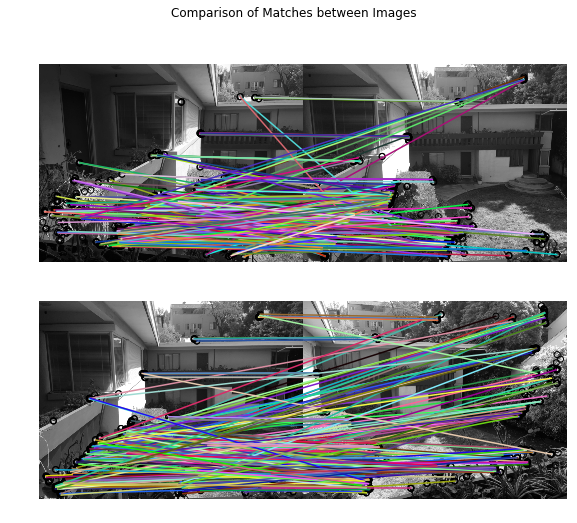

In [6]:
#visualize the matches
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

plot_matches(ax[0], g_images[0], g_images[1], keypoints[0], keypoints[1], matches01)
plot_matches(ax[1], g_images[1], g_images[2], keypoints[1], keypoints[2], matches12)

fig.suptitle('Comparison of Matches between Images')
ax[0].axis('off');
ax[1].axis('off');

## Use RANSAC to remove outlier keypoint matches
Although many keypoint matches are good, there are definitely incorrect matches. These will throw off later calculations. Thus, use RANSAC with a ProjectiveTransform model to try to accept only matches that fit the model and remove outliers.

THIS USUALLY WORKS WELL, BUT SOMETIMES IT DOESNT WORK. That's because its probabilistic, and sometimes it will start with a bad outlier match and the final result will be bad.

Compared to the tutorial, I allowed a lot more trials and a lot higher residual_threshold. I found this gave better results.

In [21]:
#now use ransac to eliminate bad keypoint matches

# Select keypoints from 
#   * source (image to be registered): pano0
#   * target (reference image): pano1, our middle frame registration target
src = keypoints[0][matches01[:, 0]][:, ::-1]
dst = keypoints[1][matches01[:, 1]][:, ::-1]

model_robust01, inliers01 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=18, max_trials=3000)

# Select keypoints from 
#   * source (image to be registered): pano2
#   * target (reference image): pano1, our middle frame registration target
src = keypoints[2][matches12[:, 1]][:, ::-1]
dst = keypoints[1][matches12[:, 0]][:, ::-1]

model_robust12, inliers12 = ransac((src, dst), ProjectiveTransform,
                                   min_samples=4, residual_threshold=18, max_trials=3000)

/home/hayley/.conda/envs/my_root/lib/python3.6/site-packages/skimage/transform/_geometric.py:554: RuntimeWarning: divide by zero encountered in true_divide
  dst[:, 0] /= dst[:, 2]
/home/hayley/.conda/envs/my_root/lib/python3.6/site-packages/skimage/transform/_geometric.py:555: RuntimeWarning: divide by zero encountered in true_divide
  dst[:, 1] /= dst[:, 2]


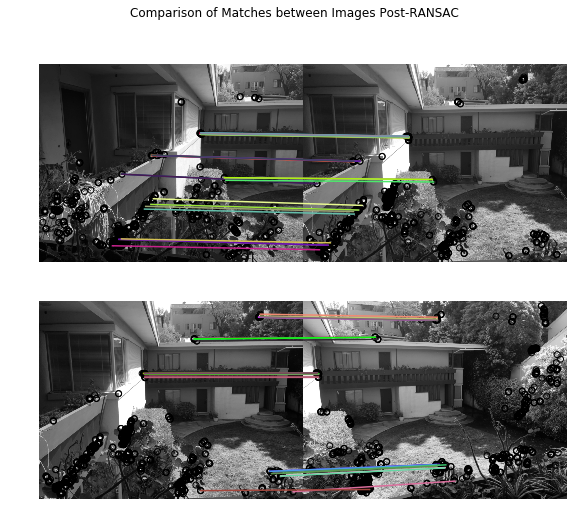

In [22]:
#visualize the results of the RANSAC.
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

plot_matches(ax[0], g_images[0], g_images[1], keypoints[0], keypoints[1], matches01[inliers01])
plot_matches(ax[1], g_images[1], g_images[2], keypoints[1], keypoints[2], matches12[inliers12])

fig.suptitle('Comparison of Matches between Images Post-RANSAC')
ax[0].axis('off');
ax[1].axis('off');

To warp to the needed shape, get the extents of the images and then warp them to the correct shape

In [23]:
# Shape of middle image, our registration target
r, c = g_images[1].shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners01 = model_robust01(corners)
warped_corners12 = model_robust12(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners01, warped_corners12, corners))

# The overall output shape will be max - min
corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)
output_shape = (corner_max - corner_min)

# Ensure integer shape with np.ceil and dtype conversion
output_shape = np.ceil(output_shape[::-1]).astype(int)

# This in-plane offset is the only necessary transformation for the middle image
offset1 = SimilarityTransform(translation= -corner_min)

transforms = [(model_robust01+offset1).inverse, offset1.inverse, (model_robust12+offset1).inverse]

warpeds = []
masks = []
for i in range(0,3):
    w = warp(g_images[i], transforms[i], order=3,
                    output_shape=output_shape, cval=-1)
    w = w.astype('float32', copy=False)
    mask = (w != -1)  # Mask == 1 inside image
    w[~mask] = 0      # Return background values to 0
    warpeds.append(w)
    masks.append(mask)


Text(0.5,0.8,'Warped Images')

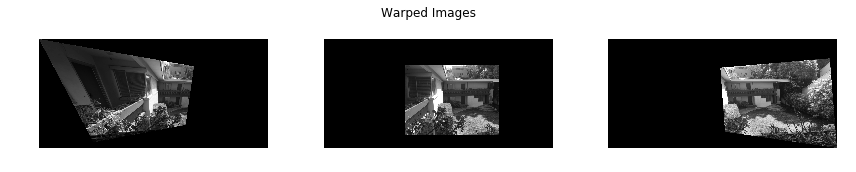

In [32]:
compare(*warpeds, figsize = (12,4));
plt.gcf().suptitle('Warped Images', y=.8)

## combine using min cost paths

In [33]:
ymax = output_shape[1] - 1
xmax = output_shape[0] - 1

mask_pts_list = []
for i in range(0,2):
    # Start anywhere along the top and bottom, and left or right of center.
    mask_pts = [[0,    (i+1)*ymax // 3],
                  [xmax, (i+1)*ymax // 3]]
    mask_pts_list.append(mask_pts)

In [34]:
#generates a cost array

def generate_costs(diff_image, mask, vertical=True, gradient_cutoff=2.):
    """
    Mostly just taken from the tutorial, but I incorporated the step that allows
    things to 'slide'
    Ensures equal-cost paths from edges to region of interest.
    
    Parameters
    ----------
    diff_image : ndarray of floats
        Difference of two overlapping images.
    mask : ndarray of bools
        Mask representing the region of interest in ``diff_image``.
    vertical : bool
        Control operation orientation.
    gradient_cutoff : float
        Controls how far out of parallel lines can be to edges before
        correction is terminated. The default (2.) is good for most cases.
        
    Returns
    -------
    costs_arr : ndarray of floats
        Adjusted costs array, ready for use.
    """
    if vertical is not True:
        return tweak_costs(diff_image.T, mask.T, vertical=vertical,
                           gradient_cutoff=gradient_cutoff).T
    
    # Start with a high-cost array of 1's
    costs_arr = np.ones_like(diff_image)
    
    # Obtain extent of overlap
    row, col = mask.nonzero()
    cmin = col.min()
    cmax = col.max()

    # Label discrete regions
    cslice = slice(cmin, cmax + 1)
    labels = label(mask[:, cslice])
    
    # Find distance from edge to region
    upper = (labels == 0).sum(axis=0)
    lower = (labels == 2).sum(axis=0)
    
    # Reject areas of high change
    ugood = np.abs(np.gradient(upper)) < gradient_cutoff
    lgood = np.abs(np.gradient(lower)) < gradient_cutoff
    
    # Give areas slightly farther from edge a cost break
    costs_upper = np.ones_like(upper, dtype=np.float64)
    costs_lower = np.ones_like(lower, dtype=np.float64)
    costs_upper[ugood] = upper.min() / np.maximum(upper[ugood], 1)
    costs_lower[lgood] = lower.min() / np.maximum(lower[lgood], 1)
    
    # Expand from 1d back to 2d
    vdist = mask.shape[0]
    costs_upper = costs_upper[np.newaxis, :].repeat(vdist, axis=0)
    costs_lower = costs_lower[np.newaxis, :].repeat(vdist, axis=0)
    
    # Place these in output array
    costs_arr[:, cslice] = costs_upper * (labels == 0)
    costs_arr[:, cslice] +=  costs_lower * (labels == 2)
    
    # Finally, place the difference image
    costs_arr[mask] = diff_image[mask]
    
    #HAYLEY ADDITION: just put this cost adjustment in the function since we always do it anyway
    #allow path to slide to optimal horizontal location
    costs_arr[0,  :] = 0
    costs_arr[-1, :] = 0
    
    return costs_arr

In [36]:
#find least cost paths
paths = []
for i in range(0,2):
    # np.abs is necessary because we don't want negative costs!
    costs = generate_costs(np.abs(warpeds[i] - warpeds[i+1]),
                         masks[i] & masks[i+1])
    
    #don't allow second path to cross the first
    if i==1:
        costs[masks[0] > 0] = 1
    
    #generate the minimum cost path
    pts, _ = route_through_array(costs, mask_pts_list[i][0], mask_pts_list[i][1], fully_connected=True)

    # Convert list of lists to 2d coordinate array for easier indexing
    pts = np.array(pts)
    paths.append(pts)


Text(0.5,0.98,'Least Cost Paths')

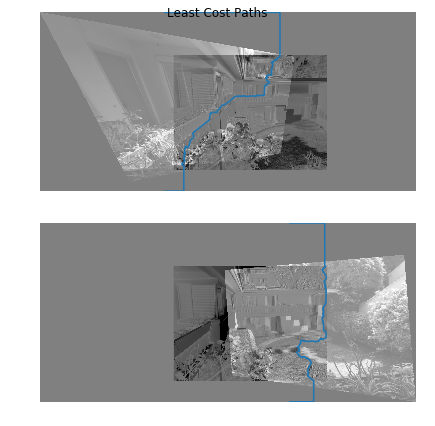

In [37]:
#visualize minimum cost paths
fig, ax = plt.subplots(2,1, figsize=(6, 6))

# Plot the difference image
ax[0].imshow(warpeds[0] - warpeds[1], cmap='gray')
ax[1].imshow(warpeds[2] - warpeds[1], cmap='gray')

# Overlay the minimum-cost path
ax[0].plot(paths[0][:, 1], paths[0][:, 0])  
ax[1].plot(paths[1][:, 1], paths[1][:, 0])  

plt.tight_layout()
ax[0].axis('off');
ax[1].axis('off');
fig.suptitle("Least Cost Paths")


In [38]:
#fill in masks to use to combine images

# Start with an array of zeros and place the path
fin_mask0 = np.zeros_like(warpeds[0], dtype=np.uint8)
fin_mask0[paths[0][:, 0], paths[0][:, 1]] = 1

fin_mask2 = np.zeros_like(warpeds[2], dtype=np.uint8)
fin_mask2[paths[1][:, 0], paths[1][:, 1]] = 1

#fill it in using label
fin_mask0 = (label(fin_mask0, connectivity=1, background=-1) == 1)
#I guess this time we want label = 3?
fin_mask2 = (label(fin_mask2, connectivity=1, background=-1) == 3)

## the final combination

In [39]:
fin_mask1 = ~(fin_mask0 | fin_mask2).astype(bool)
fin_masks = [fin_mask0, fin_mask1, fin_mask2]

In [40]:
def add_alpha(img, mask=None):
    """
    From the tutorial :)
    Adds a masked alpha channel to an image.
    
    Parameters
    ----------
    img : (M, N[, 3]) ndarray
        Image data, should be rank-2 or rank-3 with RGB channels
    mask : (M, N[, 3]) ndarray, optional
        Mask to be applied. If None, the alpha channel is added
        with full opacity assumed (1) at all locations.
    """
    from skimage.color import gray2rgb
    if mask is None:
        mask = np.ones_like(img)
        
    if img.ndim == 2:
        img = gray2rgb(img)
    
    return np.dstack((img, mask))

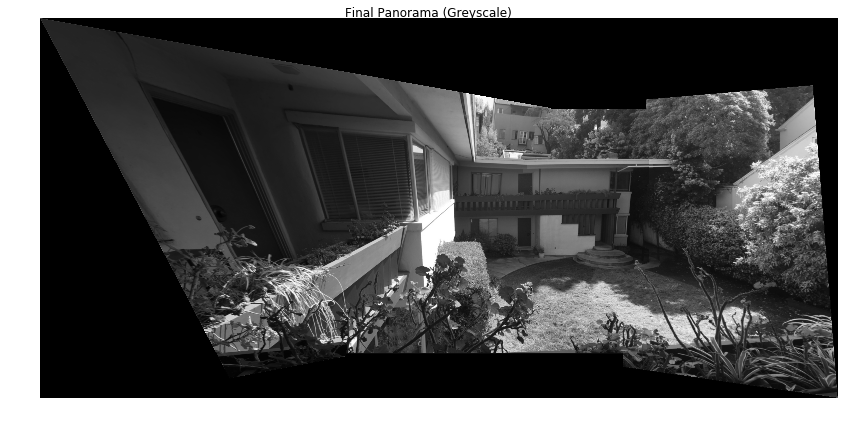

In [44]:
finals = [add_alpha(w,fin_masks[i]) for i, w in enumerate(warpeds)]

fig, ax = plt.subplots(figsize=(12, 6))

# This is a perfect combination, but matplotlib's interpolation
# makes it appear to have gaps. So we turn it off.
for f in finals:
    ax.imshow(f, interpolation='none')
fig.suptitle("Final Panorama (Greyscale)")
fig.tight_layout()
ax.axis('off');

## And the final combination, but with color

Text(0.5,0.98,'Final Panorama (Color)')

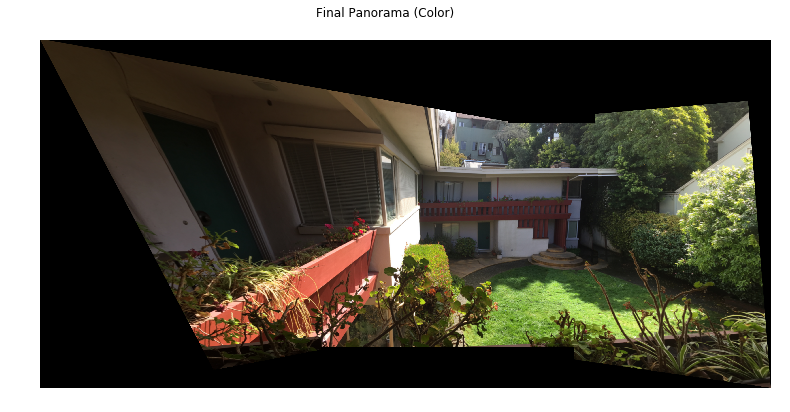

In [45]:
colors = []
for i in range(0,3):
    w = warp(images[i], transforms[i], order=3,
                   output_shape=output_shape, cval=0)
    w = w.astype('float32', copy=False)
    colors.append(w)

color_finals = [add_alpha(c, fin_masks[i]) for i, c in enumerate(colors)]

for c in color_finals:
    plt.imshow(c, interpolation='none')

plt.tight_layout()
plt.gca().axis('off');
plt.gcf().set_size_inches(12,6)
plt.gcf().suptitle("Final Panorama (Color)")

## Extra: Image Stacking

Reprocess one of the datasets from http://www.rawastrodata.com/.  See http://www.rawastrodata.com/pages/typesofimages.html for a description of the different kind of images.

In [2]:
import matplotlib.pyplot as plt
import rawpy
import glob
from skimage.feature import register_translation
import time
import numpy as np
from skimage.transform import rescale
from skimage.filters import gaussian
import dask.array as da
from dask import delayed


## Get calibration frames
add together all dark frames and all dark_flats and divide by n to get the mean.
Also try this technique for flats.
As an alternate, register 15 of the flat frames together, and then get the mean of those.

In [42]:
#add together all dark frames
dark_paths = glob.glob('space_photos/Darks/*')
dark = rawpy.imread(dark_paths[0]).postprocess().astype('uint32')
for i, dp in enumerate(dark_paths[1:]):
    dark = dark + rawpy.imread(dp).postprocess().astype('uint32')
    
dark = dark.astype('float32')
#take the mean
dark = dark/len(dark_paths)
np.savez('dark.npz', dark)

9.489059448242188e-05
12.4574556350708
25.800570726394653
38.67722797393799
51.06942009925842
64.64759039878845


In [41]:
#and add together all dark_flats
dark_flat_paths = glob.glob('space_photos/Dark Flats/*')
#need to convert to uint32 because otherwise the strategy of adding then dividing won't work  
dark_flat = rawpy.imread(dark_flat_paths[0]).postprocess().astype('uint32')
for dp in dark_flat_paths[1:]:
    dark_flat = dark_flat + rawpy.imread(dp).postprocess().astype('uint32')
    
dark_flat = dark_flat.astype('float32')
#take the mean
dark_flat = dark_flat/len(dark_flat_paths)

np.savez('dark_flat.npz', dark_flat)

In [44]:
#the flats need to be registered, and that's really slow on my computer, so I'm just taking the first 15 for now
flat_paths = glob.glob('space_photos/Flats/*')
#we're going to register in greyscale because of memory constraints
flat = rawpy.imread(flat_paths[0]).postprocess().astype('uint32')
for fp in flat_paths[1:]:
    flat = flat + rawpy.imread(fp).postprocess().astype('uint32')
flat = flat.astype('float32')/len(flat_paths)
np.savez('mean_flats.npz', flat)

In [11]:
#the flats need to be registered, and that's really slow on my computer, so I'm just taking the first 15 for now
flat_paths = glob.glob('space_photos/Flats/*')
#we're going to register in greyscale because of memory constraints
flat = skimage.color.rgb2grey(rawpy.imread(flat_paths[0]).postprocess())
registrations = []
for fp in flat_paths[1:15]:
    im=skimage.color.rgb2grey(rawpy.imread(fp).postprocess())
    registrations.append(register_translation(flat, im))

np.savez('translation_first_15_flats.npz', np.asarray(registrations))

In [ ]:
shifts = np.asarray([r[0] for r in registrations])
#shift and add all the images, filling missing sections with 0
flat = rawpy.imread(flat_paths[0]).postprocess().astype('uint32')

for i,fp in enumerate(flat_paths[1:15]):
    shift = shifts[i,:].astype('int16')
    im=rawpy.imread(fp).postprocess()
    if shift[0] >= 0 and shift[1] >=0:
        im = np.pad(im[shift[0]:, shift[1]:,:], ((shift[0],0),(shift[1],0),(0,0)), 'constant')
    elif shift[0] < 0 and shift[1] >= 0:
        im = np.pad(im[:im.shape[0]+shift[0], shift[1]:,:], ((0,-shift[0]),(shift[1],0),(0,0)), 'constant')
    elif shift[0] < 0 and shift[1] < 0:
        im = np.pad(im[:im.shape[0]+shift[0], :im.shape[1]+shift[1],:],
                    ((0,-shift[0]),(0, -shift[1]),(0,0)), 'constant')
    elif shift[0] >= 0 and shift[1] <0:
        im = np.pad(im[shift[0]:, :im.shape[1]+shift[1],:], ((shift[0],0),(0, -shift[1]),(0,0)), 'constant')
    flat = flat + im.astype('uint32')

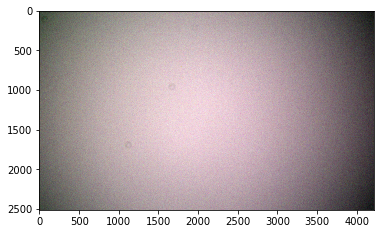

In [39]:
shifts = shifts.astype('int16')
cropped_flat = flat[shifts[:,0].max(): flat.shape[0] + shifts[:,0].min(),
               shifts[:,1].max(): flat.shape[1] + shifts[:,1].min(),:]
cropped_flat = cropped_flat.astype('float32')/15

#normalize array to be between 0 and 1 in each channel so I can visualize results
x2 = np.empty((2510, 4222, 3))
for i in range(0,3):
    x2[:,:,i] = cropped_flat[:,:,i] - cropped_flat[:,:,i].min()
    x2[:,:,i] = x2[:,:,i]/x2[:,:,i].max()
plt.imshow(x2)

In [40]:
np.savez('cropped_aligned_15_flats', cropped_flat)

In [43]:
dark_flat = np.load('dark_flat.npz')['arr_0']
dark = np.load('dark.npz')['arr_0']
flat = np.load('cropped_aligned_15_flats.npz')['arr_0']
#crop dark_flat to accomodate the cropping of flat
shifts = np.load('translation_first_15_flats.npz')['arr_0']
shifts = shifts[:,0]
shifts=np.asarray([s for s in shifts])
shifts = shifts.astype('int16')
#subtract the dark_flat from the flat to correct its values
cropped_df= dark_flat[shifts[:,0].max(): dark_flat.shape[0] + shifts[:,0].min(),
               shifts[:,1].max(): dark_flat.shape[1] + shifts[:,1].min(),:]
normed_flat = flat-cropped_df
np.savez('cropped_normed_flat.npz', normed_flat)

#alternatively use the unregistered flat images
flat = np.load('mean_flats.npz')['arr_0']
normed_flat = flat - dark_flat
np.savez('mean_normed_flat.npz', normed_flat)

(14, 2)


Now try to handle the light images and what to do with them. I made use of a dask array to preprocess the images, because otherwise they used a lot of memory

In [7]:
#use dask and delay to handle the very large number of images 
@delayed
def read(filename):
    return rawpy.imread(filename).postprocess()

paths = glob.glob('space_photos/Lights/*')
sample = rawpy.imread(paths[0]).postprocess()
lazy_values = [read(p) for p in paths]     # Lazily evaluate imread on filepath

arrays = [da.from_delayed(lazy_value,           # Construct a small Dask array
                          dtype='float32',   # for every lazy value
                          shape=sample.shape)
          for lazy_value in lazy_values]

stack = da.stack(arrays, axis=0)                # Stack all small Dask arrays into one

In [48]:
#correct each light frame by subtracting the mean dark frame and dividing by the corrected flat frame
dark = np.load('dark.npz')['arr_0']
stack2 = stack - dark
#crop the image to accomodate the cropping of flat
shifts = np.load('translation_first_15_flats.npz')['arr_0']
shifts = shifts[:,0]
shifts=np.asarray([s for s in shifts])
shifts = shifts.astype('int16')
flat = np.load('cropped_normed_flat.npz')['arr_0']
flat[np.where(flat==0)] = 1
stack2 = stack2[:,shifts[:,0].max(): sample.shape[0] + shifts[:,0].min(),
               shifts[:,1].max(): sample.shape[1] + shifts[:,1].min(),:]/flat

stack4 = stack2.rechunk(chunks = {0:3})

Just trying to visualize what they'd look like if I did calibration after.

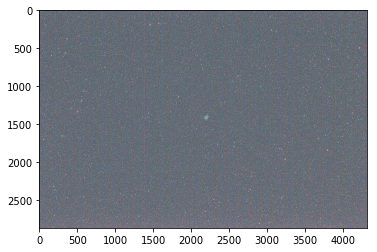

In [12]:
flat = np.load('mean_normed_flat.npz')['arr_0']
plt.imshow(rerange(raw_mean-flat))

In [5]:
#In theory, I need to register these to each other first.
#But first just check out what they'd look like like this
fin_mean = stack4.mean(axis=0).compute()


In [9]:
def rerange(arr):
    """scales photos to have values between 0 and 1"""
    arr=arr-arr.min()
    arr=arr/arr.max()
    return arr

Try prepocessing for a single light frame. It doesn't look quite right?

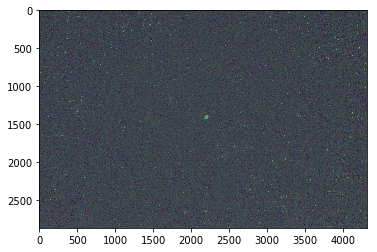

In [10]:
paths = glob.glob('space_photos/Lights/*')
dark = np.load('dark.npz')['arr_0']
dark_flat = np.load('dark_flat.npz')['arr_0']


x= (rawpy.imread(paths[8]).postprocess(output_bps=8)-dark.astype('uint8'))/(rawpy.imread(flat_paths[0]).postprocess()-dark_flat)

x2 = x-x.min()
x2 = x2/x2.max()
plt.imshow(x2)

Try registering without using dark or flat frames and compare the result to taking the mean without dark and flat frames

In [42]:
light_paths = glob.glob('space_photos/Lights/*')
light = skimage.color.rgb2grey(rawpy.imread(light_paths[0]).postprocess())
registrations = []
for fp in light_paths:
    im=skimage.color.rgb2grey(rawpy.imread(fp).postprocess())
    registrations.append(register_translation(light, im))

np.savez('translation_lights_no_adj.npz', np.asarray(registrations))

In [16]:
light_paths = glob.glob('space_photos/Lights/*')

shifts = np.load('translation_lights_no_adj.npz')['arr_0']

shifts = shifts[:,0]
shifts=np.asarray([s for s in shifts])
shifts = shifts.astype('int16')
#shift and add all the images, filling missing sections with 0
light = rawpy.imread(light_paths[0]).postprocess().astype('uint32')

for i,fp in enumerate(light_paths[1:15]):
    shift = shifts[i,:].astype('int16')
    im=rawpy.imread(fp).postprocess()
    if shift[0] >= 0 and shift[1] >=0:
        im = np.pad(im[shift[0]:, shift[1]:,:], ((shift[0],0),(shift[1],0),(0,0)), 'constant')
    elif shift[0] < 0 and shift[1] >= 0:
        im = np.pad(im[:im.shape[0]+shift[0], shift[1]:,:], ((0,-shift[0]),(shift[1],0),(0,0)), 'constant')
    elif shift[0] < 0 and shift[1] < 0:
        im = np.pad(im[:im.shape[0]+shift[0], :im.shape[1]+shift[1],:],
                    ((0,-shift[0]),(0, -shift[1]),(0,0)), 'constant')
    elif shift[0] >= 0 and shift[1] <0:
        im = np.pad(im[shift[0]:, :im.shape[1]+shift[1],:], ((shift[0],0),(0, -shift[1]),(0,0)), 'constant')
    light = light + im.astype('uint32')

In [17]:
shifts = shifts.astype('int16')
cropped_light = light[shifts[:,0].max(): light.shape[0] + shifts[:,0].min(),
               shifts[:,1].max(): light.shape[1] + shifts[:,1].min(),:]
cropped_light = cropped_light.astype('float32')


In [10]:
cropped_light = np.load('translation_lights_no_adj.npz')['arr_0']
raw_mean = stack.rechunk(chunks = {0:3}).mean(axis=0).compute()


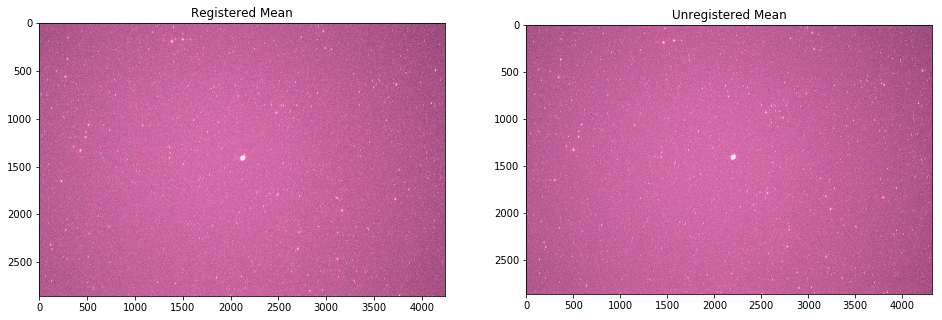

In [19]:
%matplotlib inline
plt.subplot(1,2,1)
plt.imshow(rerange(cropped_light))
plt.title('Registered Mean')
plt.subplot(1,2,2)
plt.imshow(rerange(raw_mean))
plt.title('Unregistered Mean')
plt.gcf().set_size_inches(16,8)
